In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import pandas as pd
import numpy as np

from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import lightgbm as lgb
from sklearn.kernel_ridge import KernelRidge

from multiprocessing import Lock, Manager
from multiprocessing.pool import Pool
from multiprocessing import cpu_count
import time

import seaborn

### first step: generate data ###

In [2]:
d  = 20

nrep = 10
beta = np.random.randn(d)

In [3]:
def getRandomSamplesOnNSphere(N , numberOfSamples, R = 1):
    X = np.random.default_rng().normal(size=(numberOfSamples , N))
    return R / np.sqrt(np.sum(X**2, 1, keepdims=True)) * X

In [4]:
def generate_y(x,beta):
    # x is numpy array with (n,d) ,beta is (d) and fixed
    N = x.shape[0]
    d = x.shape[1]
    e = np.random.normal(0, 0.5,size = N)
    vector = np.einsum('i,ij -> j', beta,x.T)
    fx = np.sqrt(4/10)*vector + np.sqrt(4/10)*(np.sqrt(1/2)*(vector**2-1))+ \
        np.sqrt(2/10)*(np.sqrt(1/10)*(vector**4 - 6*vector**2 + 3))
    y = fx + e
    return y

### second step: model ###

In [5]:
class dataset(Dataset):
    def __init__(self, data_tensor, data_target):
        self.data_target = data_target
        self.data_tensor = data_tensor 
    
    def __len__(self):
        return self.data_target.shape[0]

    def __getitem__(self, index):
        return self.data_tensor[index], self.data_target[index]



In [6]:
class Model_1(nn.Module):
    def __init__(self, input_dim, Nd = 100, drop_rate = 0.0, ):
        super(Model_1,self).__init__()
        self.model_name = '2 layer linear nn'
        
        self.hidden_dim = Nd//input_dim
        
        self.linear1 = nn.Linear(input_dim,self.hidden_dim,bias=False)
        self.act = nn.ReLU()
        self.linear2 = nn.Linear(self.hidden_dim,1,bias=False)

        # torch.set_num_threads(1)

#         for p in self.linear1.parameters():
#             nn.init.normal_(p,mean=0.0,std = 0.001)
#         for p in self.linear2.parameters():
#             nn.init.normal_(p,mean=0.0,std = 0.001)


    def forward(self,x):

        x_signal = self.linear1(x)
        x_signal = self.act(x_signal)
        out = self.linear2(x_signal)

        return out

In [7]:
class Model_2(nn.Module):
    def __init__(self, input_dim, Nd = 100, drop_rate = 0.0, ):
        super(Model_2,self).__init__()
        self.model_name = '1 layer linear nn'
        
        self.hidden_dim = Nd//input_dim
        
        self.linear1 = nn.Linear(input_dim,self.hidden_dim,bias=False)
        self.act = nn.ReLU()

        # torch.set_num_threads(1)

#         for p in self.linear1.parameters():
#             nn.init.normal_(p,mean=0.0,std = 0.001)
#         for p in self.linear2.parameters():
#             nn.init.normal_(p,mean=0.0,std = 0.001)


    def forward(self,x):

        x_signal = self.linear1(x)
        x_signal = self.act(x_signal)

        out = x_signal @ torch.FloatTensor([[1 if x%2==0 else -1 for x in range(x_signal.shape[1])]]).T

        return out

In [40]:

result_trainingerror = np.zeros((60,40))
result_testerror = np.zeros((60,40))    

for i in range(50,80):
    x_id = i /20
    for j in range(40,60):
        y_id = j/20
        
        N = int(np.ceil(np.e**(y_id * np.log(20))))
        Nd = int(np.ceil(np.e**(x_id* np.log(20))))
        LOSS_test = 0
        LOSS_train = 0
        
        for nrepitition in range(nrep):
            x = getRandomSamplesOnNSphere(d,N)
            y = generate_y(x,beta)

            x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.2,shuffle = True)
            x_train = torch.FloatTensor(x_train)
            x_test = torch.FloatTensor(x_test)
            y_train = torch.FloatTensor(y_train).unsqueeze(1)
            y_test = torch.FloatTensor(y_test).unsqueeze(1)

            train_dataset = dataset(x_train, y_train)
            test_dataset = dataset(x_test, y_test)
            train_dataloader = DataLoader(dataset= train_dataset, 
                                        batch_size = len(x_train), 
                                        shuffle= True, 
                                        drop_last= False)
            test_dataloader = DataLoader(dataset= test_dataset, 
                                        batch_size = len(x_test), 
                                        shuffle= True, 
                                        drop_last= False)
            torch.cuda.empty_cache()

            lr = 0.01

            device = torch.device('cuda:0'if torch.cuda.is_available() else 'cpu')
            model = Model_2(input_dim= d, Nd = Nd,drop_rate= 0.0).to(device)
            criterion = nn.MSELoss()
            optimizer = optim.Adam(model.parameters(), lr)

            model.train()
            
            last_loss = 0
            for epoch in range(500):

                for index, (x, y) in enumerate(train_dataloader):
                    if torch.cuda.is_available():
                        x = x.to(device)
                        y = y.to(device)
                    y_pred = model(x)
                    
                    loss = criterion(y_pred,y)
                    
#                     if np.abs(loss.item()-last_loss)< 0.000001:
#                         break
                        
                    last_loss = loss.item()
                    optimizer.zero_grad()

                    loss.backward()
                    optimizer.step()
                
                
            LOSS_train += loss.item()

            model.eval()
            loss2 = criterion(model(x_test), y_test)

            LOSS_test += loss2.item()
            
        training_error = LOSS_train /nrep
        test_error = LOSS_test /nrep
        
        result_trainingerror[i-20][j-20] = training_error
        result_testerror[i-20][j-20] = test_error
        
        print('Nd: %d, N: %d,trainingerror: %f, testerror: %f'%(Nd,N, training_error, test_error))
        
    np.save('./result/trainingerror_modifiedversion.npy',result_trainingerror)
    np.save('./result/testerror_modifiedversion.npy',result_testerror)    
         


Nd: 1789, N: 400,trainingerror: 0.000000, testerror: 0.902631
Nd: 1789, N: 465,trainingerror: 0.000000, testerror: 0.909421
Nd: 1789, N: 540,trainingerror: 0.000002, testerror: 0.765154
Nd: 1789, N: 627,trainingerror: 0.000075, testerror: 1.009456
Nd: 1789, N: 729,trainingerror: 0.000094, testerror: 0.756106
Nd: 1789, N: 846,trainingerror: 0.000708, testerror: 0.796546
Nd: 1789, N: 983,trainingerror: 0.003799, testerror: 0.787067
Nd: 1789, N: 1142,trainingerror: 0.006844, testerror: 0.832548
Nd: 1789, N: 1326,trainingerror: 0.012012, testerror: 0.708119
Nd: 1789, N: 1541,trainingerror: 0.026347, testerror: 0.717020
Nd: 1789, N: 1789,trainingerror: 0.040436, testerror: 0.732195
Nd: 1789, N: 2078,trainingerror: 0.062148, testerror: 0.803975
Nd: 1789, N: 2414,trainingerror: 0.080856, testerror: 0.690493
Nd: 1789, N: 2804,trainingerror: 0.105006, testerror: 0.700363


KeyboardInterrupt: 

In [36]:
y_test.shape

torch.Size([40, 1])

In [17]:
            model = Model_2(input_dim= d, Nd = 297,drop_rate= 0.0).to(device)
            criterion = nn.MSELoss()
            optimizer = optim.Adam(model.parameters(), lr)

            model.train()
            
            for epoch in range(500):

                for index, (x, y) in enumerate(train_dataloader):
                    if torch.cuda.is_available():
                        x = x.to(device)
                        y = y.to(device)
                    y_pred = model(x)
                    loss = criterion(y_pred,y)
                    optimizer.zero_grad()

                    loss.backward()
                    optimizer.step()
                    

                    print(loss)            
            LOSS_train += loss.item()                        
            model.eval()
            loss2 = criterion(model(x_test), y_test)

            LOSS_test += loss2

tensor(0.7797, grad_fn=<MseLossBackward0>)
tensor(0.7144, grad_fn=<MseLossBackward0>)
tensor(0.6570, grad_fn=<MseLossBackward0>)
tensor(0.6062, grad_fn=<MseLossBackward0>)
tensor(0.5624, grad_fn=<MseLossBackward0>)
tensor(0.5243, grad_fn=<MseLossBackward0>)
tensor(0.4922, grad_fn=<MseLossBackward0>)
tensor(0.4643, grad_fn=<MseLossBackward0>)
tensor(0.4409, grad_fn=<MseLossBackward0>)
tensor(0.4212, grad_fn=<MseLossBackward0>)
tensor(0.4044, grad_fn=<MseLossBackward0>)
tensor(0.3905, grad_fn=<MseLossBackward0>)
tensor(0.3782, grad_fn=<MseLossBackward0>)
tensor(0.3674, grad_fn=<MseLossBackward0>)
tensor(0.3578, grad_fn=<MseLossBackward0>)
tensor(0.3493, grad_fn=<MseLossBackward0>)
tensor(0.3414, grad_fn=<MseLossBackward0>)
tensor(0.3340, grad_fn=<MseLossBackward0>)
tensor(0.3271, grad_fn=<MseLossBackward0>)
tensor(0.3207, grad_fn=<MseLossBackward0>)
tensor(0.3149, grad_fn=<MseLossBackward0>)
tensor(0.3096, grad_fn=<MseLossBackward0>)
tensor(0.3048, grad_fn=<MseLossBackward0>)
tensor(0.30

tensor(0.1139, grad_fn=<MseLossBackward0>)
tensor(0.1137, grad_fn=<MseLossBackward0>)
tensor(0.1136, grad_fn=<MseLossBackward0>)
tensor(0.1135, grad_fn=<MseLossBackward0>)
tensor(0.1134, grad_fn=<MseLossBackward0>)
tensor(0.1133, grad_fn=<MseLossBackward0>)
tensor(0.1132, grad_fn=<MseLossBackward0>)
tensor(0.1130, grad_fn=<MseLossBackward0>)
tensor(0.1129, grad_fn=<MseLossBackward0>)
tensor(0.1128, grad_fn=<MseLossBackward0>)
tensor(0.1127, grad_fn=<MseLossBackward0>)
tensor(0.1126, grad_fn=<MseLossBackward0>)
tensor(0.1124, grad_fn=<MseLossBackward0>)
tensor(0.1123, grad_fn=<MseLossBackward0>)
tensor(0.1122, grad_fn=<MseLossBackward0>)
tensor(0.1121, grad_fn=<MseLossBackward0>)
tensor(0.1120, grad_fn=<MseLossBackward0>)
tensor(0.1119, grad_fn=<MseLossBackward0>)
tensor(0.1117, grad_fn=<MseLossBackward0>)
tensor(0.1116, grad_fn=<MseLossBackward0>)
tensor(0.1115, grad_fn=<MseLossBackward0>)
tensor(0.1114, grad_fn=<MseLossBackward0>)
tensor(0.1112, grad_fn=<MseLossBackward0>)
tensor(0.11

In [19]:
loss.item()

0.08706934005022049

In [144]:
result_trainingerror = np.load('./result/trainingerror2.npy')
result_testerror = np.load('./result/testerror2.npy')

In [145]:
result_trainingerror[np.isnan(result_trainingerror)] = 0
result_testerror[np.isnan(result_testerror)] = 0.05

Text(0.5, 1.0, 'training error')

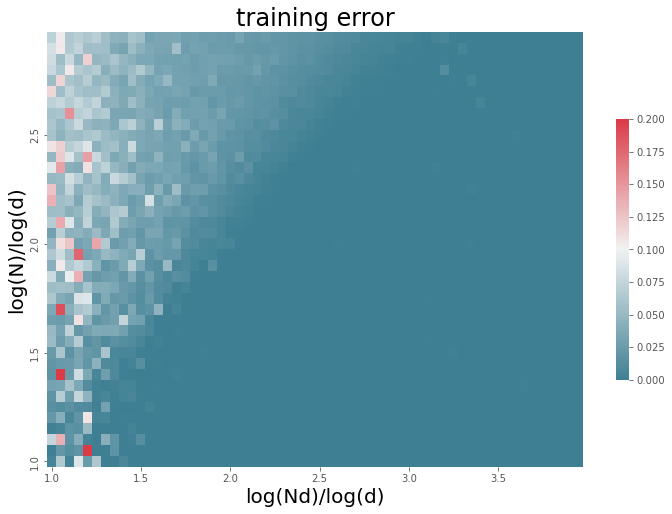

In [98]:
from matplotlib import ticker
cmap = seaborn.diverging_palette(220, 10, as_cmap=True)
f, ax = plt.subplots(figsize=(12, 8))

xxs = pd.DataFrame(result_trainingerror.T,index = [x/20+1 for x in list(range(result_trainingerror.shape[1]))],
            columns = [x/20+1 for x in list(range(result_trainingerror.shape[0]))])

seaborn.heatmap(xxs, cmap=cmap,vmin = 0,vmax = 0.2,
            linewidths=.0001, cbar_kws={"shrink": 0.6},xticklabels=10,yticklabels=10)

ax.invert_yaxis()

ax.set_ylabel('log(N)/log(d)',fontsize=20, color='k')

ax.set_xlabel('log(Nd)/log(d)',fontsize=20, color='k')

plt.title('training error', fontsize = 24,color = 'k')

Text(0.5, 1.0, 'test error')

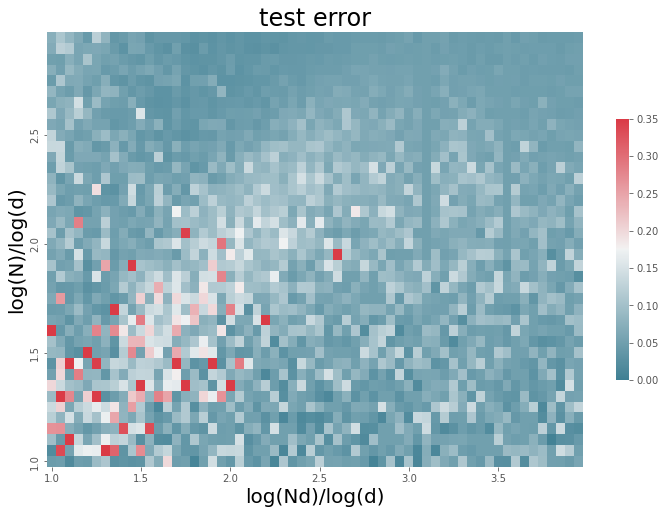

In [150]:
from matplotlib import ticker
cmap = seaborn.diverging_palette(220, 10, as_cmap=True)
f, ax = plt.subplots(figsize=(12, 8))

xxss = pd.DataFrame(result_testerror.T,index = [x/20+1 for x in list(range(result_testerror.shape[1]))],
            columns = [x/20+1 for x in list(range(result_trainingerror.shape[0]))])

seaborn.heatmap(xxss, cmap=cmap,vmin = 0,vmax = 0.35,
            linewidths=.0001, cbar_kws={"shrink": 0.6},xticklabels=10,yticklabels=10)

ax.invert_yaxis()

ax.set_ylabel('log(N)/log(d)',fontsize=20, color='k')

ax.set_xlabel('log(Nd)/log(d)',fontsize=20, color='k')

plt.title('test error', fontsize = 24,color = 'k')

In [9]:
 if torch.FloatTensor([0.002])<0.01:
        print('k')

k


In [65]:
?ax.xaxis.set_major_locator

In [146]:
for i in range(40,60):
    for j in range(40):
        if result_testerror[i][j]>0.15:
            result_testerror[i][j] = 0.05

In [149]:
for i in range(13,40):
    for j in range(40):
        if j< i-13:
            if result_testerror[i][j]>0.15:
                result_testerror[i][j] = 0.05

In [153]:
result_testerror[:,].shape

(60,)

In [249]:

result_trainingerror2 = np.zeros((45,1))
result_testerror2 = np.zeros((45,1))    
n_list = [46]
for i in range(15,60):
    x_id = i /5
    for j in range(1):
        
        N = n_list[j]
        Nd = int(np.ceil(np.e**(x_id)))
        
        for nrepitition in range(nrep):
            x = getRandomSamplesOnNSphere(d,N)
            y = generate_y(x,beta)

            x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.2,shuffle = True)
            x_train = torch.FloatTensor(x_train)
            x_test = torch.FloatTensor(x_test)
            y_train = torch.FloatTensor(y_train).unsqueeze(1)
            y_test = torch.FloatTensor(y_test).unsqueeze(1)

            train_dataset = dataset(x_train, y_train)
            test_dataset = dataset(x_test, y_test)
            train_dataloader = DataLoader(dataset= train_dataset, 
                                        batch_size = len(x_train), 
                                        shuffle= True, 
                                        drop_last= False)
            test_dataloader = DataLoader(dataset= test_dataset, 
                                        batch_size = len(x_test), 
                                        shuffle= True, 
                                        drop_last= False)
            torch.cuda.empty_cache()

            lr = 0.01

            device = torch.device('cuda:0'if torch.cuda.is_available() else 'cpu')
            model = Model_2(input_dim= d, Nd = Nd,drop_rate= 0.0).to(device)
            criterion = nn.MSELoss()
            optimizer = optim.Adam(model.parameters(), lr)
            LOSS = 0
            LOSS2 = 0
            model.train()
            
            for epoch in range(500):

                for index, (x, y) in enumerate(train_dataloader):
                    if torch.cuda.is_available():
                        x = x.to(device)
                        y = y.to(device)
                    y_pred = model(x)
                    loss = criterion(y_pred,y)
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

            #         for p in model.parameters():
            #             # print(p.grad.norm())                 
            #             torch.nn.utils.clip_grad_norm_(p, 10)  
            #         optimizer.step()
            LOSS += loss
            model.eval()
            loss2 = criterion(model(x_test), y_test)
            
            LOSS2 += loss2
            
        training_error = LOSS /nrep
        test_error = LOSS2 /nrep
        
        result_trainingerror2[i-15][j] = training_error
        result_testerror2[i-15][j] = test_error
        
        print('Nd: %d, N: %d,trainingerror: %f, testerror: %f'%(Nd,N, training_error, test_error))
        
    np.save('./result1/trainingerror1.npy',result_trainingerror2)
    np.save('./result1/testerror1.npy',result_testerror2)    
         


Nd: 21, N: 46,trainingerror: 0.061911, testerror: 0.057644
Nd: 25, N: 46,trainingerror: 0.062198, testerror: 0.745611
Nd: 30, N: 46,trainingerror: 0.049747, testerror: 0.123112
Nd: 37, N: 46,trainingerror: 0.043857, testerror: 0.173389
Nd: 45, N: 46,trainingerror: 0.005038, testerror: 0.087623
Nd: 55, N: 46,trainingerror: 0.021265, testerror: 1.191565
Nd: 67, N: 46,trainingerror: 0.008298, testerror: 0.111150
Nd: 82, N: 46,trainingerror: 0.012659, testerror: 0.361261
Nd: 100, N: 46,trainingerror: 0.000779, testerror: 0.124878
Nd: 122, N: 46,trainingerror: 0.000000, testerror: 0.049486
Nd: 149, N: 46,trainingerror: 0.000323, testerror: 0.563760
Nd: 182, N: 46,trainingerror: 0.000664, testerror: 0.106120
Nd: 222, N: 46,trainingerror: 0.000000, testerror: 0.042182
Nd: 271, N: 46,trainingerror: 0.000000, testerror: 0.064070
Nd: 331, N: 46,trainingerror: 0.000000, testerror: 0.060335
Nd: 404, N: 46,trainingerror: 0.000000, testerror: 0.103824
Nd: 493, N: 46,trainingerror: 0.000000, testerro

In [156]:
np.ceil(4)

4.0

In [160]:
np.load('./result/trainingerror2.npy')

array([[4.55249753e-03, 1.44158979e-03, 7.52650797e-02, ...,
        8.16754401e-02, 8.37643072e-02, 7.15659857e-02],
       [6.35459274e-02, 2.04691030e-02, 1.36507645e-01, ...,
        5.32738343e-02, 1.04697391e-01, 1.04651690e-01],
       [3.37138842e-03, 1.32026123e-02, 1.73560716e-02, ...,
        7.87840188e-02, 6.46702275e-02, 6.29779771e-02],
       ...,
       [9.02083339e-17, 9.34924659e-17, 1.35605819e-16, ...,
        3.65336746e-06, 1.14787954e-05, 1.02914637e-04],
       [5.55111521e-18, 7.01193478e-18, 8.57118595e-17, ...,
        1.64825164e-04, 6.69850215e-06, 1.39008029e-04],
       [6.66188038e-17, 2.62947565e-18, 7.11071388e-17, ...,
        1.80096031e-04, 2.29380257e-05, 3.14147357e-04]])

In [162]:
list(range(1))

[0]

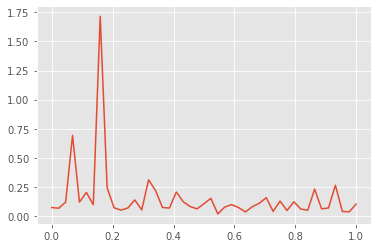

In [179]:
plt.plot(np.linspace(0,1,len(result_testerror2[0:,0])),result_testerror2[0:,0])

In [171]:
np.linspace(0,len(result_testerror2[:,0]))

array([  0.        ,   4.08163265,   8.16326531,  12.24489796,
        16.32653061,  20.40816327,  24.48979592,  28.57142857,
        32.65306122,  36.73469388,  40.81632653,  44.89795918,
        48.97959184,  53.06122449,  57.14285714,  61.2244898 ,
        65.30612245,  69.3877551 ,  73.46938776,  77.55102041,
        81.63265306,  85.71428571,  89.79591837,  93.87755102,
        97.95918367, 102.04081633, 106.12244898, 110.20408163,
       114.28571429, 118.36734694, 122.44897959, 126.53061224,
       130.6122449 , 134.69387755, 138.7755102 , 142.85714286,
       146.93877551, 151.02040816, 155.10204082, 159.18367347,
       163.26530612, 167.34693878, 171.42857143, 175.51020408,
       179.59183673, 183.67346939, 187.75510204, 191.83673469,
       195.91836735, 200.        ])

In [174]:
result_testerror2[result_testerror2>1] =0

In [196]:
list(model.linear1.parameters())[0]

Parameter containing:
tensor([[-0.0111,  0.0989,  0.0009,  ..., -0.0242, -0.1754,  0.2380],
        [ 0.1937,  0.0238,  0.0439,  ..., -0.0401, -0.0101, -0.1679],
        [-0.1198, -0.0028, -0.0468,  ...,  0.1184,  0.0079, -0.1694],
        ...,
        [ 0.0749, -0.0583, -0.2584,  ...,  0.0035,  0.0463, -0.0851],
        [ 0.1543,  0.1251, -0.0612,  ...,  0.0995, -0.1059,  0.1132],
        [-0.0901,  0.1373, -0.2855,  ..., -0.0304, -0.1341,  0.0673]],
       requires_grad=True)

In [210]:
dd = torch.FloatTensor([[1 if x%2==0 else -1 for x in range(list(model.linear1.parameters())[0].shape[0])]])

In [212]:
dd.shape

torch.Size([1, 6662])

In [213]:
list(model.linear1.parameters())[0].dot(dd)

RuntimeError: 1D tensors expected, but got 2D and 2D tensors

In [208]:
list(model.linear1.parameters())[0].shape

torch.Size([6662, 20])

In [216]:
list(model.linear1.parameters())[0],list(model.linear2.parameters())[0]

RuntimeError: 1D tensors expected, but got 2D and 2D tensors

In [217]:
x

tensor([[-1.4874e-01,  1.6240e-01,  1.8166e-01, -2.2942e-02,  1.3691e-01,
         -8.2678e-04,  3.6314e-02, -4.8702e-02,  3.2745e-01,  3.5037e-01,
          5.0410e-01, -2.2585e-01, -3.7730e-01, -3.2315e-01, -8.1960e-02,
         -6.4492e-02,  1.0028e-01, -1.9486e-01,  2.3126e-01, -3.5531e-02],
        [-2.4247e-01, -4.3026e-03, -3.6769e-01,  1.2126e-01, -3.0802e-01,
          2.3777e-01, -3.0270e-02, -1.8630e-01,  3.9810e-01,  2.0871e-01,
         -1.6687e-02, -5.5406e-02,  1.6182e-01, -1.2924e-01,  1.4724e-01,
         -9.7515e-02, -5.3652e-01,  1.0138e-01, -6.9665e-02, -1.4763e-01],
        [-1.9415e-01,  3.9637e-01,  1.4373e-01, -1.1946e-01, -2.2908e-01,
         -1.9516e-01, -2.2928e-01,  1.4441e-01,  1.5333e-01, -2.9857e-01,
         -1.4753e-01, -1.9731e-01,  1.1812e-02, -7.8945e-02, -4.9349e-01,
         -2.4990e-01, -2.5203e-01,  4.6246e-02,  1.3366e-01,  1.9247e-01],
        [ 3.5748e-02,  3.8911e-01,  3.3577e-01,  6.7642e-02,  6.1902e-02,
         -6.2974e-02,  1.1107e-01, 

In [218]:
model(x)

tensor([[-0.9856],
        [-0.4947],
        [ 0.5135],
        [ 0.2506],
        [-0.2129],
        [-0.2664],
        [-1.0198],
        [-0.2540],
        [-1.0066],
        [ 0.9400],
        [-1.1924],
        [-0.0268],
        [ 2.0826],
        [-0.9071],
        [-1.0570],
        [-0.4213],
        [-0.0959],
        [ 0.2266],
        [ 0.2104],
        [-0.8705],
        [ 0.9344],
        [ 0.1232],
        [ 0.1451],
        [-0.4126],
        [ 0.0024],
        [ 0.2534],
        [ 0.6218],
        [ 0.5972],
        [ 0.3580],
        [-0.4707],
        [ 0.6385],
        [ 0.8817],
        [-0.3112],
        [ 0.0146],
        [-0.7536],
        [ 0.1565]], grad_fn=<AddmmBackward0>)

In [222]:
x @ list(model.linear1.parameters())[0].T

tensor([[-0.0125,  0.1777,  0.1111,  ..., -0.1281, -0.0677, -0.2527],
        [-0.0026,  0.0981, -0.0396,  ...,  0.1004, -0.1017,  0.1610],
        [-0.1055, -0.0695,  0.0389,  ..., -0.1313, -0.0287,  0.1327],
        ...,
        [-0.0045,  0.0808,  0.0210,  ..., -0.0720,  0.2506,  0.0043],
        [ 0.2115, -0.0941,  0.1686,  ..., -0.1333,  0.0148,  0.2588],
        [ 0.1476, -0.1039, -0.1357,  ..., -0.0187, -0.0773, -0.1094]],
       grad_fn=<MmBackward0>)

In [247]:
class Model_2(nn.Module):
    def __init__(self, input_dim, Nd = 100, drop_rate = 0.0, ):
        super(Model_2,self).__init__()
        self.model_name = '2 layer linear nn'
        
        self.hidden_dim = Nd//input_dim
        
        self.linear1 = nn.Linear(input_dim,self.hidden_dim,bias=False)
        self.act = nn.ReLU()

        # torch.set_num_threads(1)

#         for p in self.linear1.parameters():
#             nn.init.normal_(p,mean=0.0,std = 0.001)
#         for p in self.linear2.parameters():
#             nn.init.normal_(p,mean=0.0,std = 0.001)


    def forward(self,x):

        x_signal = self.linear1(x)
        x_signal = self.act(x_signal)

        out = x_signal @ torch.FloatTensor([[1 if x%2==0 else -1 for x in range(x_signal.shape[1])]]).T

        return out

In [248]:

x = getRandomSamplesOnNSphere(d,N)
y = generate_y(x,beta)

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.2,shuffle = True)
x_train = torch.FloatTensor(x_train)
x_test = torch.FloatTensor(x_test)
y_train = torch.FloatTensor(y_train).unsqueeze(1)
y_test = torch.FloatTensor(y_test).unsqueeze(1)

train_dataset = dataset(x_train, y_train)
test_dataset = dataset(x_test, y_test)
train_dataloader = DataLoader(dataset= train_dataset, 
                            batch_size = len(x_train), 
                            shuffle= True, 
                            drop_last= False)
test_dataloader = DataLoader(dataset= test_dataset, 
                            batch_size = len(x_test), 
                            shuffle= True, 
                            drop_last= False)
torch.cuda.empty_cache()

lr = 0.01

device = torch.device('cuda:0'if torch.cuda.is_available() else 'cpu')
model = Model_2(input_dim= d, Nd = Nd,drop_rate= 0.0).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr)
LOSS = 0
LOSS2 = 0
model.train()

for epoch in range(500):

    for index, (x, y) in enumerate(train_dataloader):
        if torch.cuda.is_available():
            x = x.to(device)
            y = y.to(device)
        y_pred = model(x)
        loss = criterion(y_pred,y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

#         for p in model.parameters():
#             # print(p.grad.norm())                 
#             torch.nn.utils.clip_grad_norm_(p, 10)  
#         optimizer.step()
        print(loss.item())

34.28993606567383
1555.7650146484375
123.21859741210938
419.5163879394531
789.5841064453125
483.0692138671875
127.865478515625
80.68464660644531
248.4906463623047
350.48028564453125
274.5597229003906
126.07473754882812
46.492286682128906
76.76553344726562
148.59510803222656
172.84979248046875
127.610595703125
60.6148681640625
28.1835994720459
44.64131546020508
78.98208618164062
90.52326202392578
67.61502838134766
32.72420883178711
15.2528076171875
24.297752380371094
43.56603240966797
49.83079528808594
36.177127838134766
16.193246841430664
7.662380695343018
14.854629516601562
26.07140350341797
27.420127868652344
17.39017677307129
6.559381484985352
4.821476459503174
11.153579711914062
16.18702507019043
13.563544273376465
6.468675136566162
2.599186897277832
4.843420028686523
8.738639831542969
8.771720886230469
4.966913223266602
1.891846776008606
2.483325719833374
4.847112655639648
5.350930213928223
3.2899303436279297
1.231039047241211
1.3546503782272339
2.8457067012786865
3.34211969375610

8.699349574037285e-10
8.857879429946536e-10
9.321469152112627e-10
8.376606075444215e-10
6.795221052513511e-10
1.1816201350711708e-09
1.7912152872057163e-09
1.5146845999680636e-09
1.1104016595098187e-09
1.4375607371164278e-09
2.061884440962558e-09
1.2507416213836109e-09
1.3578661528512725e-09
1.858473708260533e-09
2.0038157799717737e-09
1.0412294360051533e-09
1.9960979535937895e-09
4.40433245429972e-09
3.6287930438305693e-09
2.6637299033183126e-09
1.248802616871103e-09
2.0705437364654244e-09
2.2228525686784906e-09
3.111542357103758e-09
1.3458154590750837e-09
2.115867037133512e-09
2.151772982017519e-09
2.160267742468136e-09
2.567089874006001e-09
2.558645517680702e-09
1.5061896174728417e-09
2.399427323496184e-09
2.068800686316763e-09
1.341507793739538e-09
1.0382293913480112e-09
1.8375236887635538e-09
1.8917207800228653e-09
2.4808963772215975e-09
1.3145515787016393e-09
1.4263057401819879e-09
2.7886402076404693e-09
3.456051445027697e-09
3.567072859311793e-09


In [243]:
mm(x).shape

torch.Size([36, 5])


torch.Size([36, 1])

In [245]:
N

46